TLDR: this notebook illustrated 'missing' LSST sources-  those sources that were detected in DECAPS, but no in LSST... 

In [1]:
import astropy.visualization as vis
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
import urllib.request
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import hstack
from astropy.table import vstack
from astropy import wcs
from itertools import product
from scipy.stats import binned_statistic as bs

Steps:<a id='toc'></a>
* [look at completeness for the decaps-lsst crossmatch](#completeness)  (the missing sources are what we want to illustrate)
* [take a first look: use x,y from decaps_clean](#first_look)(and plot histogram of number of missing sources per CCD)
* [read the LSST and DECAPS raw CCD data](#read_data)
* [show on Venn diagrams overlap of DECAPS and LSST sources](#venn_diagrams)
* [plot the S/N LSST to S/N DECAPS ratios and distributions](#sn_ratio)
* [plot the S/N vs mag for LSST and DECAPS ](#sn_mag)
* [Illustrate all sources for small region of a CCD](#illustrate_ccd)
* [Postage stamp miniatures of fields representative of different densities](#densities)

* [[Aside : interpolation example]](#interpolation)

### Check completeness using pre-crossmatched data <a id='completeness'></a>

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Saved as  completeness_single_visit_527552.png


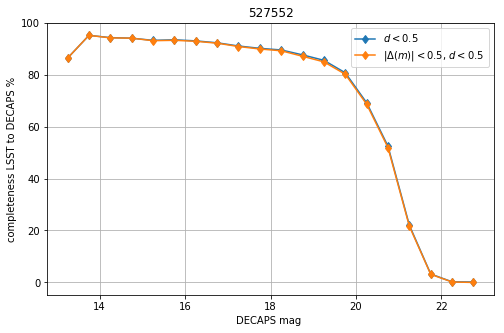

In [3]:
visit = 527552 # 
decaps_lsst = Table.read('decaps-lsst-'+str(visit)+'.txt', format='ascii')

%matplotlib inline
# plot quick completeness plot 
def plot_completeness(decaps_lsst, visit,ax,bins,decaps_match,label):
    # Plot completeness for this single visit ...    
    stat_decaps = bs(decaps_lsst['decaps_mag'], decaps_lsst['decaps_mag'] , 
                  bins = bins , statistic='count')
    decaps_count = stat_decaps.statistic

    stat_matched = bs(decaps_lsst['decaps_mag'], decaps_match , 
                      bins =bins , statistic=np.sum)
    lsst_matched_count = stat_matched.statistic
    completeness = 100 * (lsst_matched_count / decaps_count)

    # plot 
    # from bin edges to bin_centers.... 
    bin_centers = (bins[:-1] + bins[1:])/2
    ax.plot(bin_centers, completeness, marker='d',label=label)
    #ax.scatter(bin_centers, completeness)
    
    
fig,ax = plt.subplots(1,1,figsize=(8,5))
bins = np.arange(13,24,0.5)

decaps_match = np.array(decaps_lsst['d2darcsec'] <0.5).astype(int)
label = r'$d < 0.5"$'
plot_completeness(decaps_lsst, visit, ax, bins,decaps_match,label)

mask_dist = decaps_lsst['d2darcsec'] <0.5

dmag = decaps_lsst['decaps_mag'] - decaps_lsst['lsst_mag']
cut_mag = 0.5
mask_mag = abs(dmag) < cut_mag

decaps_match = np.array(mask_dist*mask_mag).astype(int)
label=r'$|\Delta(m)|<0.5$'+', '+r'$d < 0.5"$'
plot_completeness(decaps_lsst, visit, ax, bins,decaps_match,label)
ax.set_title(str(visit))
ax.set_xlabel('DECAPS mag ')
ax.set_ylabel('completeness LSST to DECAPS %')
ax.grid()
ax.legend()
fname  = 'completeness_single_visit_'+str(visit)+'.png'
plt.savefig(fname, bbox_inches='tight')
print('Saved as ', fname)

### Get x,y from decaps_clean, plot mismatches for one CCD <a id='first_look'></a>

[Jump to top](#toc)

In [4]:
decaps_clean = Table.read('decaps_clean_'+str(visit)+'.txt', format='ascii')

# these would be equal if the RA is unique for each object, which would 
# be very useful because without any objectId this becomes 
# the key on which I can perform the join.
assert len(np.unique(decaps_lsst['decaps_ra'])) == len(decaps_lsst['decaps_ra'])

# These should be equal by contruction : 
# for each element of clean DECAPS catalog I am looking for 
# an LSST match 
assert len(decaps_lsst) == len(decaps_clean)


from astropy.table import join

decaps_xy = decaps_clean[['decaps_ra', 'decaps_x', 'decaps_y']]

decaps_lsst_xy = join(left=decaps_lsst, right=decaps_xy, keys='decaps_ra',
                     join_type='inner')

decaps_lsst = decaps_lsst_xy

In [5]:
# Illustrate mismatches in each density bin...
# Since it doesn't matter whether we use the 0.5 mag difference 
# or not,  let's just use the built-in decaps_match column,
# which uses the criterion d < 0.5'',  |dmag| < 0.5 

# Parse the WCS keywords in the primary HDU
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection


mag_selection = True 
if mag_selection : 
    i=0
    mag = decaps_lsst['decaps_mag']
    mag_min,mag_max = 18,19 # mag_bins[i] ,  mag_bins[i+1]
    print('Investigating DECAPS mag ',mag_min  ,'-',mag_max)
    choose_mag = (mag_min<mag)*(mag<mag_max)
    
# choose a way of selecting matches / mismatches ...
use_only_separation = False 
if use_only_separation  :
    print('Using only d2d < 0.5 arcsec')
    mask_distance = decaps_lsst['d2darcsec'] <0.5
    choose_matches  = mask_distance 
    choose_mismatches = np.bitwise_not(mask_distance)
else  :  # use separation and dmag 
    print('Using d2d and dmag')
    mask_distance = decaps_lsst['d2darcsec'] < 0.5
    dm = abs(decaps_lsst['decaps_mag'] - decaps_lsst['lsst_mag'])
    mask_dmag = dm < 0.5 
    choose_matches  = mask_distance * mask_dmag
    choose_mismatches = np.bitwise_not(choose_matches)
    
print('Of ', np.sum(choose_mag), ' sources in that mag bin ' )
print(np.sum(choose_mag*choose_mismatches), ' are mismatches ')

Investigating DECAPS mag  18 - 19
Using d2d and dmag
Of  49897  sources in that mag bin 
6010  are mismatches 


In [147]:
#decaps_lsst

The CCD with biggest number of mismatches is : 46
completeness_single_visit_ccdhist_527552.png


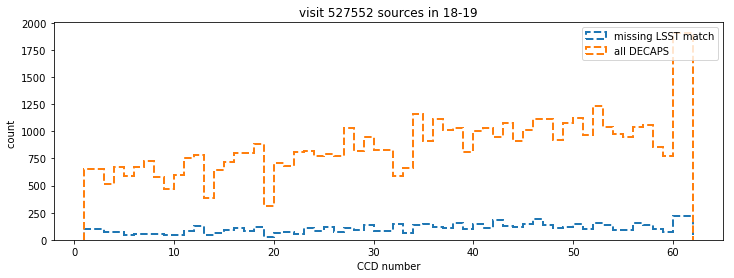

In [6]:
# This shows that 
# the mismatches in  a selected magnitude 
# range are equally distributed among
# CCDS, i.e. there is no particularly
# 'terrible' CCD ...
fig,ax = plt.subplots(1,1,figsize=(12,4))

# define bins as being the CCDnumbers.... 
values = np.unique(decaps_lsst['ccdnum'])
ax.hist(decaps_lsst['ccdnum'][choose_mag*choose_mismatches], bins=values,
       histtype='step', lw=2, ls='--', label='missing LSST match')

ax.hist(decaps_lsst['ccdnum'][choose_mag], bins=values,
       histtype='step', lw=2, ls='--', label='all DECAPS')

ax.set_xlabel('CCD number')
ax.set_ylabel('count ')
ax.legend()
ax.set_title('visit '+str(visit)+ ' sources in '+str(mag_min) +'-'+str(mag_max))
# Find which CCD has the biggest amount of DECAPS 
# sources that do not have an LSST counterpart
values, counts = np.unique(decaps_lsst['ccdnum'][choose_mag*choose_mismatches],
                         return_counts=True)   
print('The CCD with biggest number of mismatches is :', values[counts == max(counts)][0])
fname='completeness_single_visit_ccdhist_'+str(visit)+'.png'
print(fname)
plt.savefig(fname, 
            bbox_inches='tight')

In [77]:
# Select CCD, read in the calexp image for 
# the image data ...
ccd_num = 4
ccdnum = str(ccd_num).zfill(2)

choose_ccd = decaps_lsst['ccdnum'] == ccd_num

outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
calexp_file = 'calexp-0'+str(visit)+'_'+ccdnum+'.fits'
calexp_hdu = fits.open(outDir +'calexp/'+ calexp_file)

# grab the LSST mask and image data 
image_data = calexp_hdu[1].data
mask_data = calexp_hdu[2].data

# Read the LSST CCD raw data source catalog
lsst_zeropoint = calexp_hdu[0].header['MAGZERO']    

lsst_stack = Table() 
outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
fname = 'src-0'+str(visit)+'_'+ccdnum+'.fits'
hdu = fits.open(outDir +'src/'+ fname)

# convert to an AstroPy table 
ccd_data = Table(hdu[1].data)
flux = ccd_data['base_PsfFlux_flux'].data
fluxErr = ccd_data['base_PsfFlux_fluxSigma'].data
flags = Table(ccd_data['flags']) 
parent = ccd_data['parent']
nchild = ccd_data['deblend_nChild']

print('N_total_sources ',len(flags))
        
# remove sources that have either of this flags 'on'
# 61: flagEdge   67: flagInterpolatedCenter 
f1 = flags['col'+str(61)] 
f2 = flags['col'+str(67)] 
mask_bad_flags = np.bitwise_not(f1 | f2) 
print('N_removed_flags ',np.sum(~mask_bad_flags))

# only consider positive fluxes... 
mask_neg_fluxes = flux > 0
print('N_removed_neg_flux ', np.sum(~mask_neg_fluxes))

# mask low signal to noise sources .... 
mask_low_sn = (flux / fluxErr ) > 5 
print('N_removed_low_SN ',np.sum(~mask_low_sn))

# mask isolated parents
mask_isolated = (parent == 0 ) * ( nchild == 0 )
print('N_isolated ', np.sum(mask_isolated))

# mask blended sources 
mask_blended = (parent == 0 ) * (nchild > 0 )
print('N_blended ',  np.sum(mask_blended))

# mask deblended children
mask_deblended = (parent > 0 ) * (nchild == 0)
print('N_deblended ' ,np.sum(mask_deblended))

# mask weird objects 
#mask_weird = (parent>0) * (nchild > 0)
#N_weird += np.sum(mask_weird)

# combine the flags....
mask_isolated_or_deblended = mask_isolated | mask_deblended  # OR 
mask_keep_total = mask_neg_fluxes * mask_low_sn * mask_bad_flags *\
    mask_isolated_or_deblended # AND 
    
# store the source masks 
removed_sources = {'kept sources': mask_keep_total,
                   'blended sources' : mask_blended, 
                   'negative fluxes':  ~mask_neg_fluxes,
                   'S/N <5  sources':  ~mask_low_sn, 
                   'flags: Edge or InterpolatedCenter': ~mask_bad_flags
                  }


# we keep those with mask_isolated or mask_deblended ,
# those which do not have negative fluxes, do not have low SN,  
# and do not have bad flags 


# we remove those that are neither isolated nor deblended :
# mask_blended,  
# those that have negative fluxes  ~mask_neg_fluxes
# that have low SN  ~mask_low_sn
# that have bad flags  ~mask_bad_flags
print('N_removed_total ',np.sum(~mask_keep_total) )

# select all sources
ccd_lsst_good = ccd_data#[mask_keep_total]

fluxG = ccd_lsst_good['base_PsfFlux_flux']
fluxErrG =  ccd_lsst_good['base_PsfFlux_fluxSigma'].data
ccd_lsst_good['lsst_mag'] = -2.5* np.log10(fluxG)  + lsst_zeropoint
ccd_lsst_good['lsst_magerr'] = (5.0 / (2*np.log(10))) * (fluxErrG / fluxG)    

# rename columns 
ccd_lsst_good.rename_column('coord_ra', 'lsst_ra')
ccd_lsst_good.rename_column('coord_dec', 'lsst_dec')
        
# keep only most relevant info... 
ccd_lsst  =  ccd_lsst_good[['lsst_mag', 'lsst_magerr','lsst_ra', 'lsst_dec',
                           'base_SdssCentroid_x',
                           'base_SdssCentroid_y','base_PsfFlux_flux',
                           'base_PsfFlux_fluxSigma']] 

# add a column saying from which ccd these sources come from....
ccd_lsst['ccdnum'] = ccd_num

# add to the stack
lsst_stack    = vstack([lsst_stack ,ccd_lsst] )





N_total_sources  7485
N_removed_flags  35
N_removed_neg_flux  10
N_removed_low_SN  646
N_isolated  1881
N_blended  1253
N_deblended  4351
N_removed_total  1784


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in log10


decaps missing lsst match  2
decaps missing lsst match  2
decaps missing lsst match  2
decaps missing lsst match  15
decaps with lsst match 5548
kept sources 5701
blended sources 1253
negative fluxes 10
S/N <5  sources 646
flags: Edge or InterpolatedCenter 35
Saving as  visit_527552_ccd04_detections1.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


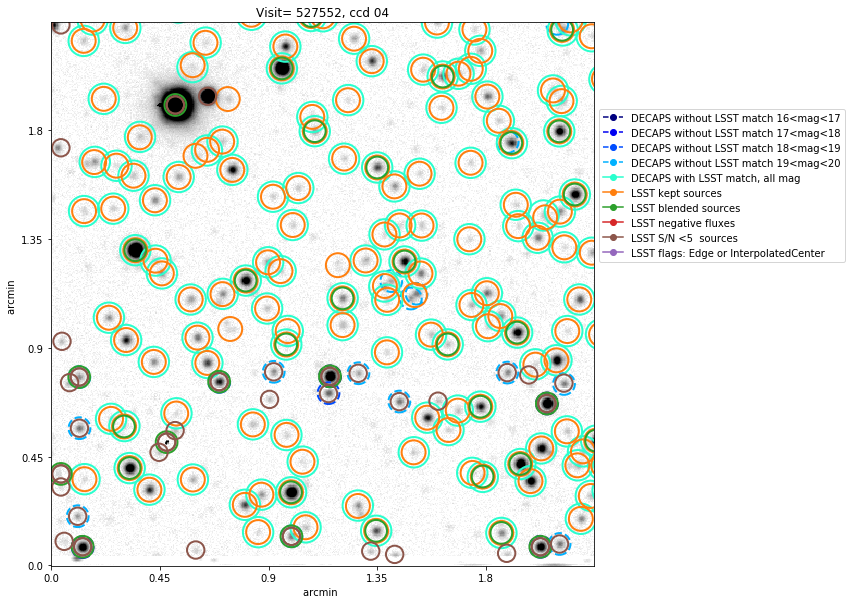

In [32]:


# show a small region of that CCD 
xmin,xmax = 0, 500 # ,1000 # 1000,1500
ymin,ymax = 0, 500#, 1000 # 500,1000
norm = ImageNormalize(stretch=SqrtStretch())

# initialize the plotting space 
plot = True
if plot :
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(image_data[xmin:xmax, ymin:ymax].T,
             cmap='Greys', origin='lower', norm=norm,
             vmax = 500, vmin = 2)
    
ax_legend_handles = []
import matplotlib
import matplotlib.lines as mlines

cmap = matplotlib.cm.get_cmap('jet')
N = 10
colors = (np.arange(N+1)/N)  # ensure a range between 0 and 1 
k = 0

# plot decaps sources that lack LSST match 
plot_bad_decaps = True
plot_good_decaps = True 
plot_clean_lsst = False
plot_raw_lsst = True

# mag_bins[i] ,  mag_bins[i+1]
#print('Investigating DECAPS mag ',mag_min  ,'-',mag_max)


if plot_bad_decaps  : 
    for mag_min in np.arange(16,20):
        mag_max = mag_min + 1
        choose_mag = (mag_min<mag)*(mag<mag_max)
        
        x = decaps_lsst['decaps_x']# 
        y = decaps_lsst['decaps_y'] 
        
        choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
        mask = choose_mismatches * choose_ccd * choose_mag * choose_pos
        print('decaps missing lsst match ',np.sum(mask))
        
        xcords = x[mask]
        ycords = y[mask]
        #x = decaps_lsst[mask]['decaps_mag']
        #normed_color  = (x-min(x))/(max(x)-min(x))
        #import matplotlib
        #cmap = matplotlib.cm.get_cmap('jet')
        #color= cmap(normed_color)
        patches = []
        color = cmap(colors[k])
        for xx,yy in zip(xcords-xmin,ycords-ymin):#, color):
            # https://matplotlib.org/devdocs/api/_as_gen/matplotlib.patches.Circle.html 
            #color = cmap((i+1)/N)
            circ = Circle((xx,yy), radius=10,alpha=1, fill=False, lw=2, ec=color,
                         ls='--')  #'red'
            #patches.append(circ)
            ax.add_patch(circ)
    
        # make a circle for the legend , one circle per marking type ... 
        #circle = Circle((xx,yy), radius=9,alpha=1, fill=False, lw=2,ec='red', 
        #                 label='DECAPS without LSST match')
        line = mlines.Line2D([], [], color=color, ls='--', marker='o', alpha=1,
                             label='DECAPS without LSST match '+\
                             str(mag_min)+'<mag<'+str(mag_max))
        ax_legend_handles.append(line)

        k += 1 
    
    
# plot decaps sources that have LSST match 

if plot_good_decaps  : 
    x = decaps_lsst['decaps_x']
    y = decaps_lsst['decaps_y']
    choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
    mask = choose_ccd *  choose_matches  * choose_pos
    print('decaps with lsst match',np.sum(mask))
    xcords = x[mask] 
    ycords = y[mask]
    color = cmap(colors[k])
    for xx,yy in zip(xcords-xmin,ycords-ymin):
        circ = Circle((xx,yy), radius=14,alpha=1, lw=2,fill=False, ec=color)#'magenta')
        ax.add_patch(circ) 
        
    # make a circle for the legend , one circle per marking type ..   
    #circle = Circle((xx,yy), radius=14,alpha=1, lw=2,fill=False, ec='magenta', 
    #                 label='DECAPS with LSST match ')
    line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                         label='DECAPS with LSST match, all mag ')
    ax_legend_handles.append(line)
    k += 1 
    
    
# plot all clean lsst sources

if plot_clean_lsst  :       
    # also plot all the LSST detections ....
    lsst_clean = Table.read('lsst_clean_'+str(visit)+'.txt', format='ascii')

    # select CCD 
    mask_ccd = lsst_clean['ccdnum'] == ccd_num
    #mask_mag = (mag_min < lsst_clean['lsst_mag'] )*(lsst_clean['lsst_mag']<mag_max)
    lsst = lsst_clean[mask_ccd]
    
    # convert ra,dec to CCD coords ...
    w = wcs.WCS(calexp_hdu[1].header)

    # first need to express the ra,dec in terms of pixel location on the image ...
    radec_lsst = np.column_stack((360*lsst['lsst_ra'] / (2*np.pi), 
                                  360*lsst['lsst_dec']/(2*np.pi)))
    pixcrd_lsst = w.wcs_world2pix(radec_lsst,1)

    # make columns for lsst  ra,dec based x,y coords
    xcords = np.ravel(np.hsplit(pixcrd_lsst,2)[1])
    ycords = np.ravel(np.hsplit(pixcrd_lsst,2)[0])   
    color = cmap(colors[k])
    
    for xx,yy in zip(xcords-xmin,ycords-ymin):
        circ = Circle((xx,yy), radius=13,alpha=1, fill=False, ec=color,
                     ls='--')#'green')
        ax.add_patch(circ)
        
    # add a patch to legend 
    line = mlines.Line2D([], [], color=color, ls='--', marker='o', alpha=1,
                         label='LSST input sources, all mag ')
    ax_legend_handles.append(line)
    k+=1 
    
# set yes to plot all LSST sources from 
# CCD source catalog that did not make it 
# to the clean catalog, 
# with distinction as to the reason about why they didn't make it ...
colors = [ 'tab:orange', 'tab:green', 'tab:red', 
           'tab:brown', 'tab:purple','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
#['tab:olive', 'orange', 'brown', 'green', 'magenta'

if plot_raw_lsst :
    for j,reason in enumerate(removed_sources.keys()):# ):
        print(reason, np.sum(removed_sources[reason]))
        mask = removed_sources[reason]

        # make columns for lsst  ra,dec based x,y coords
        ycords = lsst_stack[mask]['base_SdssCentroid_x']#['base_GaussianCentroid_x']
        xcords = lsst_stack[mask]['base_SdssCentroid_y']
        color = colors[j]
        for xx,yy in zip(xcords-xmin,ycords-ymin):
            circ = Circle((xx,yy), radius=11-j,alpha=1, lw=2,
                          fill=False, ec=color)#colors[j])
            ax.add_patch(circ)

        # add a patch to legend 
        line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                             label='LSST '+reason)
        ax_legend_handles.append(line)   
        k += 1 
    
plot_mask = False
if plot_mask : 
    mask_filter  =  2**1 + 2**2 + 2**3 + 2**4 + 2**6 + 2**7 #+ 2**8)
    #mask_filter = 2**5
    ax.imshow(mask_data[xmin:xmax, ymin:ymax].astype(int).T & mask_filter, 
            cmap='Greys', origin='lower', norm=norm,
             vmax = 1, vmin = 0, alpha=0.8)

# CALEXP 
x_px_scale = calexp_hdu[0].header['PIXSCAL1'] 
y_px_scale = calexp_hdu[0].header['PIXSCAL2'] 

# translate x ticks 
new_labels = [str((item +xmin)*x_px_scale/60) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# translate y ticks 
new_labels = [str((item +ymin)*y_px_scale/60) for item in ax.get_yticks()]
ax.set_yticklabels(new_labels)
ax.set_xlabel('arcmin ')
ax.set_ylabel('arcmin ')
    
ax.set_title('Visit= '+str(visit)+ ', ccd ' + ccdnum )

# add a legend with meaning of circles  to the panels 
plt.legend(bbox_to_anchor=(1,0.7),
             fancybox=True, loc="center left",
         handles = ax_legend_handles, ncol=1)
    
# saving the plot ... 
if plot_mask :
    fname = 'visit_'+str(visit)+'_ccd'+ccdnum+'_'+str(mag_min)+'-'+\
    str(mag_max)+'d2d_mask.png'
else : 
    fname = 'visit_'+str(visit)+'_ccd'+ccdnum+'_detections1.png'
print('Saving as ', fname)
plt.savefig(fname, bbox_inches='tight')

### DECAPS-LSST : illustration - keeping all sources <a id='read_data'></a>

[Jump to top](#toc)

All the functions are defined below, so this should be all needed to get the plots ... 

In [3]:
from astropy.table import Column

################################################
# Read in the raw DECAPS catalog for the visit 
################################################\

# select visit 
visit = 611980

# read the imdb to download the DECAPS catalog if needed
imdb = Table.read('../raw_data/decaps_catalogs/imdb_2cols.txt',
                  format='ascii')
# set where we should look for DECAPS catalog c
singleDir = '../raw_data/decaps_catalogs/single_epoch/'
cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]
file_name  = singleDir + cat_name
print('The single-band catalog name corresponding to visit %d is %s' %(visit, cat_name))

# the cat name is based on the image name ... 
singleDir = '../raw_data/decaps_catalogs/single_epoch/'
file_name  = singleDir + cat_name

# check if the catalog already exists
if cat_name not in  os.listdir(singleDir) : 
    print('Downloading the catalog...')# if not, download it ...
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
    urllib.request.urlretrieve(url, file_name)

#open the decaps catalog ...
decaps_hdu = fits.open(file_name)
  
print('Reading DECAPS src catalogs looping over CCDs')
N_total_sources = 0
N_bad_flags = 0
N_neg_flux=0
N_low_SN=0

# use the decaps single-epoch zeropoint 
decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
print('decaps single-epoch zeropoint is ', decaps_zeropoint)

## read in all the info from the decaps single-epoch catalog
decaps_stack = Table()

# make a dictionary of ccdnumber vs hduposition
ccd_name_dict = {}
cat_decaps_dict = {}
for i in range(1,len(decaps_hdu[:])) : 
    if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
        ccdnum = decaps_hdu[i].header['CCDNUM']
        detpos = decaps_hdu[i].header['DETPOS']
        ccd_name_dict[ccdnum] = detpos
        cat_decaps_dict[ccdnum] = int(i+2)

skip_ccds = [31]
ccds = np.array(list(ccd_name_dict.keys()))
ccd_numbers = ccds[np.bitwise_not(np.in1d(ccds, skip_ccds))]

# loop over CCDs... 
for i,ccd_number  in enumerate(ccd_numbers) :
    if i % 10 == 0 :
        print(i,'/', len(ccd_numbers))
    ccdnum = str(ccd_number).zfill(2)

    # read in the DECAPS catalog from the HDU 
    hdupos = cat_decaps_dict[ccd_number]
    ccd_data =  Table(decaps_hdu[hdupos].data) 
    flux = ccd_data['flux'].data
    fluxErr = ccd_data['dflux'].data
    
    # calculate magnitudes only for sources that do 
    # not have a negative flux 
    ccd_data['decaps_mag'] = Column(data=[0], dtype=float)
    ccd_data['decaps_magerr'] = Column(data=[0], dtype=float)
    m = flux > 0
    ccd_data['decaps_mag'][m] = -2.5 * np.log10(flux[m]) + decaps_zeropoint
    ccd_data['decaps_magerr'][m] = (5.0 / (2*np.log(10))) * (fluxErr[m] / flux[m])

    ccd_data.rename_column('ra', 'decaps_ra')
    ccd_data.rename_column('dec', 'decaps_dec')
    
    ccd_data.rename_column('x', 'decaps_x')
    ccd_data.rename_column('y', 'decaps_y')
    
    decaps_stack = vstack([decaps_stack, ccd_data])
    
print('Done reading DECAPS ')

################################################
# Read in the raw LSST catalog for the visit 
################################################

outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'

# first check calexp for zero point magnitude
# it is exactly the same for all CCDs in a mosaic 
calexp_files = os.listdir(outDir+'calexp/')
calexp_hdu = fits.open(outDir+'calexp/' + calexp_files[0])
lsst_zeropoint = calexp_hdu[0].header['MAGZERO']
print('\nThe LSST- measured zeropoint for decam is %f'%lsst_zeropoint)
lsst_stack = Table() 
outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
for i, ccd_number  in enumerate(ccd_numbers) :
    if i % 10 == 0 :
        print(i,'/', len(ccd_numbers))
    ccdnum = str(ccd_number).zfill(2) 
    fname = 'src-0'+str(visit)+'_'+ccdnum+'.fits'
    hdu = fits.open(outDir +'src/'+ fname)

    # convert to an AstroPy table 
    ccd_data = Table(hdu[1].data)
    flux = ccd_data['base_PsfFlux_flux'].data
    fluxErr = ccd_data['base_PsfFlux_fluxSigma'].data
    
    # calculate mags only for positive sources 
    ccd_data['lsst_mag'] = Column(data=[0], dtype=float)
    ccd_data['lsst_magerr'] = Column(data=[0], dtype=float)
    m = flux > 0 
    ccd_data['lsst_mag'][m] = -2.5* np.log10(flux[m])  + lsst_zeropoint
    ccd_data['lsst_magerr'][m] = (5.0 / (2*np.log(10))) * (fluxErr[m] / flux[m])    
    
    # store flags as a new column 
    flags = Table(ccd_data['flags']) 
    parent = ccd_data['parent']
    nchild = ccd_data['deblend_nChild']

    # save which sources  have either of this flags 'on'
    # 61: flagEdge   67: flagInterpolatedCenter 
    f1 = flags['col'+str(61)] 
    f2 = flags['col'+str(67)] 
    mask_bad_flags = np.bitwise_not(f1 | f2) 
    
    ## yes  if the flag is on 
    ccd_data['is_flagEdge_or_InterpolatedCenter'] = ~mask_bad_flags 
    
    ## yes if isolated parent 
    ccd_data['is_isolated_parent'] =  (parent == 0 ) * ( nchild == 0 )
    
    # yes if  blended sources 
    ccd_data['is_blended_source']  = (parent == 0 ) * (nchild > 0 )
    
    # mask deblended children
    ccd_data['is_deblended_child'] = (parent > 0 ) * (nchild == 0)
    
    # rename columns 
    ccd_data.rename_column('coord_ra', 'lsst_ra')
    ccd_data.rename_column('coord_dec', 'lsst_dec')

    # add a column saying from which ccd these sources come from....
    ccd_data['ccdnum'] = ccd_number
    
    # keep only most relevant info... 
    ccd_lsst  =  ccd_data[['lsst_mag', 'lsst_magerr','lsst_ra', 'lsst_dec',
                               'base_SdssCentroid_x',
                               'base_SdssCentroid_y','base_PsfFlux_flux',
                               'base_PsfFlux_fluxSigma',
                               'is_flagEdge_or_InterpolatedCenter',
                               'is_isolated_parent', 'is_blended_source',
                               'is_deblended_child','ccdnum','parent',
                               'deblend_nChild','id']]

    # add to the stack
    lsst_stack    = vstack([lsst_stack ,ccd_lsst] )

print('Done reading LSST')


The single-band catalog name corresponding to visit 611980 is c4d_170122_055542_ooi_g_v1.cat.fits
Reading DECAPS src catalogs looping over CCDs
decaps single-epoch zeropoint is  29.047
0 / 59
10 / 59
20 / 59
30 / 59
40 / 59
50 / 59
Done reading DECAPS 

The LSST- measured zeropoint for decam is 29.047000
0 / 59
10 / 59
20 / 59
30 / 59
40 / 59
50 / 59
Done reading LSST


In [23]:
#decaps_stack

Cross-match different subsets ... 

In [4]:
def cross_match_decaps_lsst(decaps_stack,lsst_stack,k,
                            sources=['decaps', 'lsst'] ):
    '''
    Matching sources[0] to sources[1]. Thus the outcome will have 
    the same length as sources[0]. If sources[1] has a shorter length than
    sources[0], we may end up with single source[1]  object being a good
    match to different sources[0]  objects - this is unavoidable. 
    
    '''
    # Cross-match different subsets...
    # LSST cleaning
    mask_well_deblended = lsst_stack['is_isolated_parent'] | lsst_stack['is_deblended_child']
    mask_good_fluxes = lsst_stack['base_PsfFlux_flux'] > 0
    mask_sn_gt5 = (lsst_stack['base_PsfFlux_flux']/lsst_stack['base_PsfFlux_fluxSigma']) > 5
    mask_bad_flags = lsst_stack['is_flagEdge_or_InterpolatedCenter'] <1 
    mask_lsst  = mask_well_deblended  * mask_good_fluxes * mask_sn_gt5 * mask_bad_flags

    # DECAPS cleaning 
    mask_decaps_filter = 2**1+  2**3+  2**4+  2**5+  2**6+  2**8+  2**20+  2**22
    mask_bad_flags = np.bitwise_not(decaps_stack['flags'] & mask_decaps_filter > 0)
    mask_sn_gt5 = decaps_stack['flux']/decaps_stack['dflux'] > 5 
    mask_good_fluxes = decaps_stack['flux'] > 0
    mask_decaps= mask_good_fluxes * mask_sn_gt5 * mask_bad_flags
    
    source1 ,  source2 = sources 
    if k==0 : 
        title = 'All '+source1.upper()+' to all '+source2.upper()
        print(title)
        decaps = decaps_stack
        lsst=  lsst_stack
        
    if k==1 : 
        title = 'All '+source1.upper()+' to clean '+source2.upper()
        print(title)
        decaps = decaps_stack
        lsst  = lsst_stack[mask_lsst]

    if k==2 :
        title = 'Clean '+source1.upper()+' to clean '+source2.upper()
        print(title)
        decaps = decaps_stack[mask_decaps]
        lsst  = lsst_stack[mask_lsst]

    print('DECAPS: using ',len(decaps),'/',len(decaps_stack))
    print('LSST: using ',len(lsst),'/',len(lsst_stack))    
    
    # Cross-matching is super fast, no need to store the results ... 
    source1 ,  source2 = sources 
    if source1 is 'lsst':
        unit1,unit2 = u.radian, u.degree
        cat1,cat2   = lsst,     decaps
        
    elif source1 is 'decaps':
        unit1, unit2 = u.degree, u.radian
        cat1, cat2   = decaps,   lsst

        
    print('\nCross-matching ',source1, ' to ', source2)
    

    print('There are ', len(cat1), source1, 'sources, ') 
    print('   and ', len(cat2), source2, 'sources. ')

    coord1 = SkyCoord(ra  = cat1[source1+'_ra']*unit1, 
                      dec = cat1[source1+'_dec']*unit1)
    coord2 = SkyCoord(ra  = cat2[source2+'_ra']*unit2, 
                      dec = cat2[source2+'_dec']*unit2)

    table_names = [source1, source2]
    dmag_cols = [source1+'_mag', source2+'_mag']

    # Steps common to all types of crossmatching 
    idx, d2d, d3d = coord1.match_to_catalog_sky(coord2)  

    # stack the two catalogs 
    cat12 = hstack([cat1 ,cat2[idx]], table_names=table_names)

    cat12['d2darcsec'] = d2d.arcsec

    return cat12,title


In [5]:
# All DECAPS to All LSST ( k=2 )
# and vice versa .... 
cat12,title = cross_match_decaps_lsst(decaps_stack,lsst_stack,k=2,
                                     sources=['decaps','lsst'])
cat21,title = cross_match_decaps_lsst(decaps_stack,lsst_stack,k=2, 
                                      sources=['lsst','decaps'])

Clean DECAPS to clean LSST
DECAPS: using  308325 / 315722
LSST: using  196989 / 273032

Cross-matching  decaps  to  lsst
There are  308325 decaps sources, 
   and  196989 lsst sources. 
Clean LSST to clean DECAPS
DECAPS: using  308325 / 315722
LSST: using  196989 / 273032

Cross-matching  lsst  to  decaps
There are  196989 lsst sources, 
   and  308325 decaps sources. 


### Check the overlap in cross-matched sources ... <a id='venn_diagrams'></a> 

In [7]:
cat12

<Table masked=True length=308325>
   decaps_x      decaps_y     flux  ...         id            d2darcsec   
   float64       float64    float32 ...       int64            float64    
------------- ------------- ------- ... ------------------ ---------------
16.8330369173 871.953976348 47703.9 ... 262843412875577370   10.5076476006
23.1708864639 618.603869273  3989.8 ... 262843412875577354    7.8526867598
   24.0479005 168.266999971 4861.99 ... 262843412875575338   23.8498579044
24.8787026692  730.53758293 2823.91 ... 262843412875577359   8.78026626665
28.8328668977  44.086195472 3034.67 ... 262843412875575338   49.1794909042
33.9449076989 553.319969399 17375.5 ... 262843412875577388 0.0254393760339
38.6838476063 399.982130346 593.719 ... 262843412875577351 0.0260070163346
38.6868817087 1022.23943857 33950.0 ... 262843412875577349 0.0251657880342
45.0089246472 81.3778840991 5746.92 ... 262843412875575338    38.502647345
47.7306391414 398.661003837 594.236 ... 262843412875577352  0.069304997295
          ...           ...     ... ...                ...             ...
3630.66362728 1477.59452536 394.235 ... 262843674868585007   7.16558775599
3731.12514861 1319.64598008 351.493 ... 262843674868585133   4.60551766292
3750.35202027 1619.47809264 650.551 ... 262843674868585109   13.9723963046
3785.80594579 1248.30002045 339.828 ... 262843674868585239   13.0568693885
3818.49102435 1290.31900705 330.054 ... 262843674868582329    5.3102797173
3857.24202819 1542.31184069 334.044 ... 262843674868585202   3.96462757559
3862.80053493 1212.36322461 929.862 ... 262843674868585236   4.19127992725
3878.20861719  1209.4222831 364.047 ... 262843674868585241   2.76864195937
3891.42360442 1192.75376929 353.114 ... 262843674868585240   3.05441955353
3900.28034453 1182.13509005 331.219 ... 262843674868585242   5.75623391766

In [10]:
# 1 matching DECAPS to LSST  :: cat12 
# the number of rows is the number of DECAPS id, 
# since we take  each DECAPS source  and look for an
# LSST match 

print('Number of rows', len(cat12))
print('Number of unique decapsid', len(np.unique(cat12['decapsid'])))

# Of those that were matched : there would be only one decapsid and lsstid per 
# match 
m = cat12['d2darcsec'] < 0.5
decapsid = cat12[m]['decapsid']
lsstid = cat12[m]['id']

# Number of unique decapsid and lsstid is very close in the matched 
# pairs : there are only a few decapsid that are matched to more 
# than one lsstid ...

# There is as many unique decapsid as rows  - 
# not even one decapsid appears twice 
values, counts = np.unique(decapsid, return_counts=True)
#np.where(counts>1) => (array([], dtype=int64),)

# However, there are LSST sources where the 
# same lsstid appears more than once 
values, counts = np.unique(lsstid, return_counts=True)

# Select those lsstid that appear more than once 
multiple_lsstid = values[np.where(counts > 1)]

# This selects only those DECAPSid 
# that correspond to only one LSSTid 
decapsid_unique = decapsid[~np.in1d(lsstid, multiple_lsstid)]
lsstid_unique = lsstid[~np.in1d(lsstid, multiple_lsstid)]
countAB = len(decapsid_unique)

Number of rows 308325
Number of unique decapsid 308325


In [12]:
# Use the vanilla modules 
from modules import crossmatch_catalogs
from matplotlib_venn import venn2
visit_table = Table.read('decaps_lsst_visit_info.txt', format='ascii')

# Test for just few ... 
for i, visit in enumerate(visit_table['visit'].astype(int)[:1]) : 
    print('\nvisit ', visit, i , '/', len(visit_table))
    cat12 = crossmatch_catalogs(sources=['decaps','lsst'],visits=[visit],
                        crossmatch_type = 'pipeline',
                        save_tables=False)
    cat21 = crossmatch_catalogs(sources=['lsst','decaps'],visits=[visit],
                        crossmatch_type = 'pipeline',
                        save_tables=False)

    # check which decapsid are in the decaps-lsst match ...
    m = cat12['d2darcsec'] < 0.5
    decapsid12 = np.unique(cat12['decaps_id'][m])
    N_decaps_missing = np.sum(~m) 
    print('Number of DECAPS missing matches is ', N_decaps_missing)

    print('Number of unique decapsid12 ', len(decapsid12), '?= ', np.sum(m),
          ' number of matched objects' ) # this means that there is one decaps ID per match 

    m = cat21['d2darcsec'] < 0.5
    decapsid21 = np.unique(cat21['decaps_id'][m])
    print('Number of unique decapsid21', len(decapsid21), '?= ', np.sum(m),
          ' number of matched objects' ) # this means that there is one decaps ID per match 
     # this means that there is one decaps ID per match 

    #common_id = set(decapsid12) & set(decapsid21)
    common_ids = np.intersect1d(decapsid12.data.data, 
                                decapsid21.data.data, assume_unique=True)
    N_matched_shared = len(common_ids)
    print('Number of common_ids is ', len(common_ids))

    N_lsst_missing = np.sum(~m)
    print('Number of LSST missing matches is ', N_lsst_missing)

    N_per_sq_deg = visit_table[visit_table['visit'] == visit]['mean_N_per_sq_deg'].data[0]

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    venn2(subsets=(N_decaps_missing,N_lsst_missing,N_matched_shared), 
          set_labels=('DECAPS', 'LSST'),ax=ax)
    ax.set_title('visit '+str(visit)+', '+str(int(N_per_sq_deg))+'/sq. deg')
    plt.savefig('venn_diagram_visit_'+str(visit)+'.png', bbox_inches='tight')


visit  525814 0 / 50
Cross-matching  decaps  to  lsst
There are  195624 decaps sources, 
   and  163093 lsst sources. 
 154372 cat1 srcs have a cat2 match within 0.5 arcsec
 162053 cat1 srcs have a  cat2 match within 0.5 mag
 153561 cat1 srcs have an cat2 match     fulfilling both criteria
Cross-matching  lsst  to  decaps
There are  163093 lsst sources, 
   and  195624 decaps sources. 
 154326 cat1 srcs have a cat2 match within 0.5 arcsec
 157562 cat1 srcs have a  cat2 match within 0.5 mag
 153558 cat1 srcs have an cat2 match     fulfilling both criteria
Number of DECAPS missing matches is  41252
Number of unique decapsid12  154372 ?=  154372  number of matched objects
Number of unique decapsid21 154326 ?=  154326  number of matched objects
Number of common_ids is  154326
Number of LSST missing matches is  8767


In [170]:
m12 = cat12['d2darcsec'] < 0.5
N_decaps_missing = np.sum(~m12) 
print('Number of DECAPS missing matches is ', N_decaps_missing)

m21 = cat21['d2darcsec'] < 0.5
N_lsst_missing = np.sum(~m21)
print('Number of LSST missing matches is ', N_lsst_missing)


for label in ['decaps_id', 'lsst_id']:#label = 'decaps_id'
    #label = 'lsst_id'
    print('Using ', label)
    # check which decapsid are in the decaps-lsst match ...
    id12 = np.unique(cat12[label][m12])

    print('Number of unique ',label,'12 ', len(id12), '?= ', np.sum(m12),
          ' number of matched objects' ) # this means that there is one decaps ID per match 

    id21 = np.unique(cat21[label][m21])
    print('Number of unique ',label,'21', len(id21), '?= ', np.sum(m21),
          ' number of matched objects' ) # this means that there is one decaps ID per match 
     # this means that there is one decaps ID per match \

    #common_id = set(decapsid12) & set(decapsid21)
    common_ids = np.intersect1d(id12.data.data, 
                                id21.data.data, assume_unique=True)
    N_matched_shared = len(common_ids)
    print('Number of common_ids is ', len(common_ids))

    #N_per_sq_deg = visit_table[visit_table['visit'] == visit]['mean_N_per_sq_deg'].data[0]



Number of DECAPS missing matches is  382473
Number of LSST missing matches is  11113
Using  decaps_id
Number of unique  decaps_id 12  458931 ?=  458931  number of matched objects
Number of unique  decaps_id 21 458160 ?=  458170  number of matched objects
Number of common_ids is  458160
Using  lsst_id
Number of unique  lsst_id 12  458160 ?=  458931  number of matched objects
Number of unique  lsst_id 21 458170 ?=  458170  number of matched objects
Number of common_ids is  458160


In [138]:
#https://python-graph-gallery.com/170-basic-venn-diagram-with-2-groups/
#https://www.programiz.com/python-programming/set
#http://fouryears.eu/2012/10/13/venn-diagrams-in-python/
#from matplotlib_venn import venn2
#venn2([set(['A', 'B', 'C', 'D','E']), set(['D', 'E', 'F'])])

### Plot the distribution of matched sources  : LSST S/N to DECAPS S/N <a id='sn_ratio'></a>

[Jump to top](#toc)

In [353]:
def plot_sn_ratio(cat12,matched=True) :
    sn_decaps = cat12['flux'] / cat12['dflux']
    sn_lsst = cat12['base_PsfFlux_flux'] / cat12['base_PsfFlux_fluxSigma']
    if matched : 
        m_d2d = cat12['d2darcsec'] < 0.5 
        isMatched = 'with'
    else:
        m_d2d = cat12['d2darcsec'] > 0.5 
        isMatched = 'no'
    #dm = abs(cat12['decaps_mag'] - cat12['lsst_mag'])
    #m_dmag = dm < 0.5 
    ax_legend_handles = []
    colors = ['orange', 'blue']
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    for i, mags  in enumerate([[12,23], [18,20]]):
        m1,m2 = mags[0], mags[1]
        m_mag = (m1<cat12['decaps_mag'])*(cat12['decaps_mag']<m2)
        m = m_d2d*m_mag #* m_dmag
        ax.scatter(sn_lsst[m], sn_decaps[m] / sn_lsst[m], s=0.01,c=colors[i])
        line = mlines.Line2D([], [], c=colors[i],ls='-', marker='o', alpha=1,
                             label=str(m1)+'<mag<'+str(m2))
        ax_legend_handles.append(line) 
    plt.legend(bbox_to_anchor=(0.7,0.7),
               fancybox=True, loc="center left",
            handles = ax_legend_handles, ncol=1)
    ax.set_xlim(0,250)
    ax.set_ylim(0.5,1.75)
    ax.grid()
    ax.set_xlabel('S/N LSST')
    ax.set_ylabel('S/N DECAPS  /  S/N LSST')
    ax.set_title(title+ ' '+isMatched+' match within 0.5 arcsec')
    f = str(visit)+ '_SN_comparison_'+str(k)+'_SN_ratio_'+isMatched+'.png'
    print(f)
    plt.savefig(f, bbox_inches='tight')

Plot the S/N distribution for DECAPS without LSST matches : 

In [354]:
def plot_sn_distrib(cat12, title,matched=True, k=0):
    sn_decaps = cat12['flux'] / cat12['dflux']

    # select mismatches 
    if matched : 
        m_d2d = cat12['d2darcsec'] < 0.5 
        isMatched = 'with'
    else:
        m_d2d = cat12['d2darcsec'] > 0.5 
        isMatched = 'no'
    
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    colors  = ['green', 'red','orange','blue']
    # select magnitudes
    for i,mags in enumerate([[17,18],[18,19],[19,20]]):
        m1,m2 = mags[0], mags[1]
        m_mag = (m1<cat12['decaps_mag'])*(cat12['decaps_mag']<m2)
        m = m_d2d*m_mag
        ax.hist( sn_decaps[m] ,  histtype='step', lw=2, bins=50,
               color = colors[i], label=str(m1)+'<mag<'+str(m2))
    ax.legend()
    ax.grid()
    ax.set_xlabel('S/N DECAPS')
    ax.set_ylabel('count')
    ax.set_title(title+' '+isMatched+'  match within 0.5 arcsec')
    f = str(visit)+ '_SN_comparison_'+str(k)+'_SN_distrib_'+isMatched+'_match.png'
    print(f)
    plt.savefig(f, bbox_inches='tight')

All DECAPS to all LSST
DECAPS: using  714305 / 714305
LSST: using  395446 / 395446

Cross-matching  decaps  to  lsst
There are  714305 decaps sources, 
   and  395446 lsst sources. 
527552_SN_comparison_0_SN_ratio_with.png
527552_SN_comparison_0_SN_distrib_with_match.png
527552_SN_comparison_0_SN_distrib_no_match.png
All DECAPS to clean LSST
DECAPS: using  714305 / 714305
LSST: using  296232 / 395446

Cross-matching  decaps  to  lsst
There are  714305 decaps sources, 
   and  296232 lsst sources. 
527552_SN_comparison_1_SN_ratio_with.png
527552_SN_comparison_1_SN_distrib_with_match.png
527552_SN_comparison_1_SN_distrib_no_match.png
Clean DECAPS to clean LSST
DECAPS: using  707412 / 714305
LSST: using  296232 / 395446

Cross-matching  decaps  to  lsst
There are  707412 decaps sources, 
   and  296232 lsst sources. 
527552_SN_comparison_2_SN_ratio_with.png
527552_SN_comparison_2_SN_distrib_with_match.png
527552_SN_comparison_2_SN_distrib_no_match.png


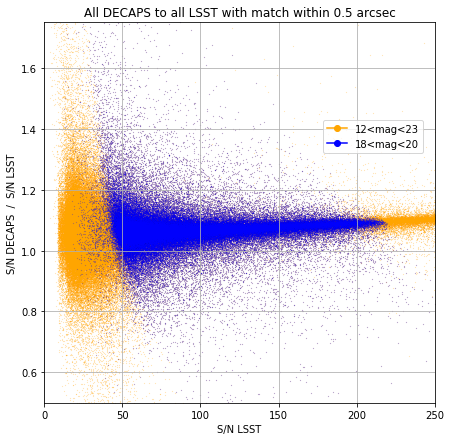

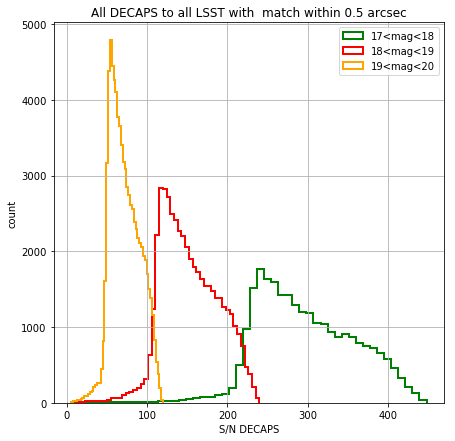

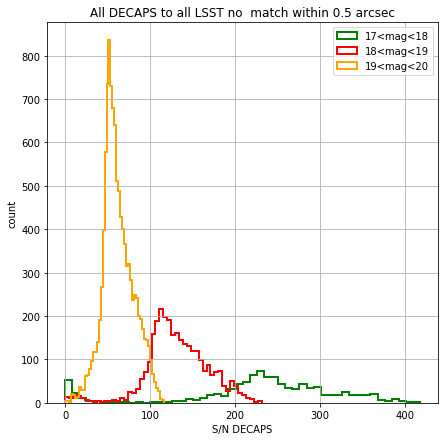

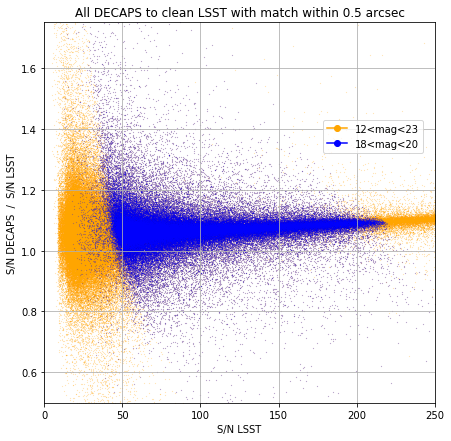

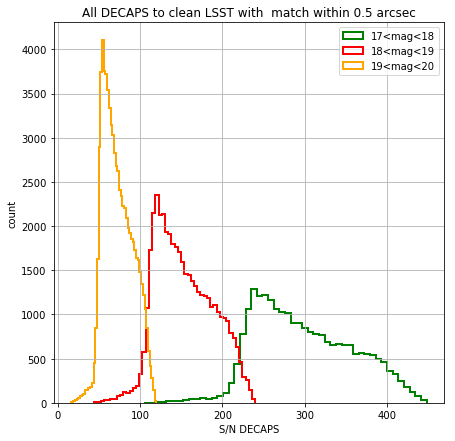

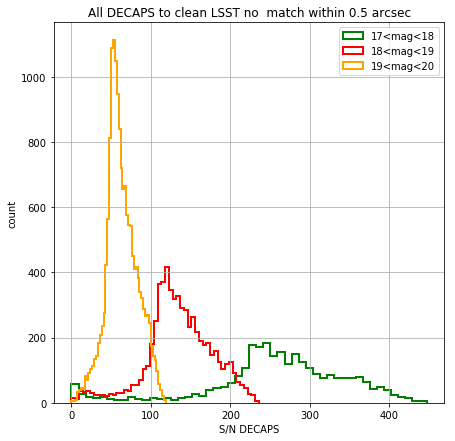

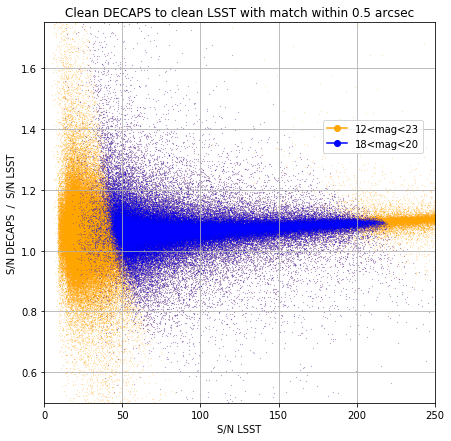

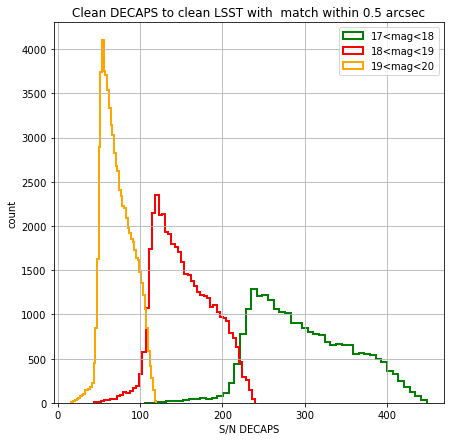

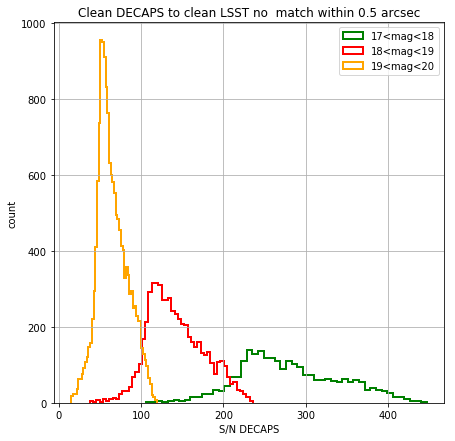

In [387]:
# All DECAPS to All LSST 
for k in range(3):
    cat12,title = cross_match_decaps_lsst(decaps_stack,lsst_stack,k)
    plot_sn_ratio(cat12, matched=True)
    plot_sn_distrib(cat12, title,matched=True,k=k)
    plot_sn_distrib(cat12, title,matched=False,k=k)

Illustrate anything on the actual image ... 

### Plot the S/N vs magnitude <a id='sn_mag'></a>

[Jump to top](#toc)

* for good lsst sources ( just keeping isolated parents and deblended children):

644035_LSST_mag_vs_SN.png


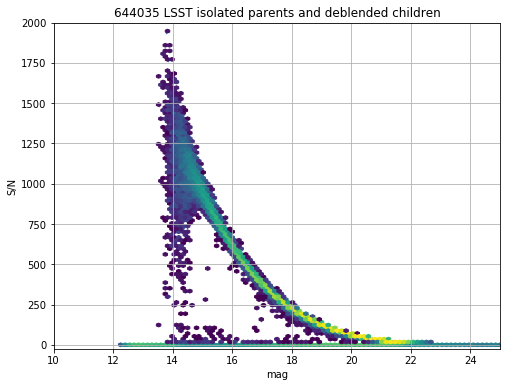

In [27]:
m = lsst_stack['is_isolated_parent'] | lsst_stack['is_deblended_child']
mag  = lsst_stack['lsst_mag']
sn = lsst_stack['base_PsfFlux_flux'] /  lsst_stack['base_PsfFlux_fluxSigma']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(mag,sn,s=0.1)
ax.hexbin(mag,sn,extent=(10,25,0,2000), mincnt=1, bins='log')
ax.set_xlim(10,25)
ax.set_ylim(-25,2000)
ax.set_xlabel('mag')
ax.set_ylabel('S/N')
ax.grid()
ax.set_title(str(visit)+' LSST isolated parents and deblended children')
fname = str(visit)+'_LSST_mag_vs_SN.png'
print(fname)
plt.savefig(fname, bbox_inches='tight')

Plot the same for DECAPS: 

644035_DECAPS_mag_vs_SN_zoom.png


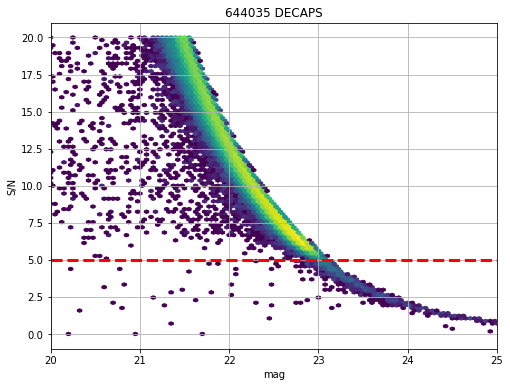

In [28]:
mag  = decaps_stack['decaps_mag']
sn = decaps_stack['flux'] / decaps_stack['dflux']
fig,ax = plt.subplots(1,1,figsize=(8,6))
#ax.scatter(mag,sn,s=0.1)
ax.hexbin(mag,sn,extent=(20,25,0,20), mincnt=1, bins='log')
ax.set_xlim(20,25)
#ax.set_ylim(-25,2000)
ax.axhline(5, ls='--', lw=3, c='red')
ax.set_xlabel('mag')
ax.set_ylabel('S/N')
ax.grid()
ax.set_title(str(visit)+' DECAPS')
fname = str(visit)+'_DECAPS_mag_vs_SN_zoom.png'
print(fname)
plt.savefig(fname, bbox_inches='tight')

So single-visit $5\sigma$ limit for visit 611980 is about 22.9 mag....

### Illustrate CCD region using both DECAPS and LSST raw data <a id='illustrate_ccd'></a>

[Jump to top](#toc)

Necessary : define masks telling how we select LSST sources 

In [13]:
#isolated_parents = (lsst_stack['parent'] == 0 )*(lsst_stack['deblend_nChild']==0)
#deblended_children = (lsst_stack['parent'] > 0) * (lsst_stack['deblend_nChild'] == 0)
#blended_sources   = (lsst_stack['parent'] == 0)*(lsst_stack['deblend_nChild']>0)

# define the LSST masks : one table 
# for the entire visit ...

## yes  if the flag is on 
#ccd_data['is_flagEdge_or_InterpolatedCenter'] = ~mask_bad_flags 


# parent = ccd_data['parent']
# nchild = ccd_data['deblend_nChild']

## yes if isolated parent 
#ccd_data['is_isolated_parent'] =  (parent == 0 ) * ( nchild == 0 )

# yes if  deblended child
#ccd_data['is_deblended_child'] = (parent > 0 ) * (nchild == 0)

# yes if  blended source
#ccd_data['is_blended_source']  = (parent == 0 ) * (nchild > 0 )

mask_well_deblended = lsst_stack['is_isolated_parent'] | lsst_stack['is_deblended_child']
mask_good_fluxes = lsst_stack['base_PsfFlux_flux'] > 0
mask_sn_gt5 = (lsst_stack['base_PsfFlux_flux'] / \
               lsst_stack['base_PsfFlux_fluxSigma']) > 5
mask_bad_flags = lsst_stack['is_flagEdge_or_InterpolatedCenter'] < 1 
mask_lsst  = mask_well_deblended  * mask_good_fluxes * mask_sn_gt5 * mask_bad_flags


# 'blended sources':lsst_stack['is_blended_source'],  would just 
# point to the location of the blend - it is not the parent, 
# adn should NOT  be kept !  

# either of these two is 'good' : no need to illustrate them 
# both, otherwise it becomes too confusing ... 
#'isolated parents':lsst_stack['is_isolated_parent'],
#'deblended children': lsst_stack['is_deblended_child'],
            
lsst_source_selection = { 'good sources' : mask_lsst,
                          'S/N <5  sources':(lsst_stack['base_PsfFlux_flux'] / \
                                           lsst_stack['base_PsfFlux_fluxSigma']) < 5,
                         'isolated parents':lsst_stack['is_isolated_parent'],
                         'deblended children': lsst_stack['is_deblended_child'],
                         'blended object' : lsst_stack['is_blended_source'],
                         'negative fluxes':lsst_stack['base_PsfFlux_flux']< 0,
                         'flags: Edge or InterpolatedCenter':
                         lsst_stack['is_flagEdge_or_InterpolatedCenter']  >0
                        }





In [14]:
import matplotlib
import matplotlib.lines as mlines

def read_calexp_data(ccdInt, visit):
    ccdStr = str(ccdInt).zfill(2)
    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
    calexp_file = 'calexp-0'+str(visit)+'_'+ccdStr+'.fits'
    calexp_hdu = fits.open(outDir +'calexp/'+ calexp_file)

    # grab the LSST mask and image data 
    image_data = calexp_hdu[1].data
    mask_data = calexp_hdu[2].data

    # grab the pixel scale ... 
    x_px_scale = calexp_hdu[0].header['PIXSCAL1'] 
    y_px_scale = calexp_hdu[0].header['PIXSCAL2'] 
    px_scale = [x_px_scale, y_px_scale]

    return image_data, mask_data, px_scale

#sourceColors = [ 'tab:orange', 'tab:green','tab:brown', 
#                         'tab:red', 'tab:purple','tab:pink', 'tab:gray', 
#                         'tab:olive', 'tab:cyan'], 
        
def illustrate_ccd_region(image_data, cat12,lsst_stack, 
                          lsst_source_selection, px_scale,
                          xbounds=[0,500], ybounds=[0,500],
                          decapsSnLimits=[50,200], decapsMags=[[18,19],[19,20]],
                          plot_raw_decaps = True , plot_raw_lsst = True ,
                          ccdInt=1, l = 0, savefig=True,fname = None,
                         useArcmin = False, annotate = False,lowSNbyLine =False,
                         sourceTypePlot = ['good sources' , 'S/N <5  sources',
                        'isolated parents','deblended children','blended object',
                         'negative fluxes', 'flags: Edge or InterpolatedCenter'],
                          sourceColorsDict =  { 'good sources' : 'green',
                         'isolated parents':'orange',
                         'deblended children':'olive',
                         'blended object' :'magenta',
                         'negative fluxes': 'brown',
                         'flags: Edge or InterpolatedCenter': 'red'},
                          mask_bits =   { 0:'MP_BAD', 1:'MP_SAT', 2:'MP_INTRP', 
                           3:'MP_CR', 4:'MP_EDGE', 5:'MP_DETECTED',
                           6:'MP_DETECTED_NEGATIVE', 7:'MP_SUSPECT',8:'MP_NO_DATA'},
                          plot_mask = False,plotDecapsMatches=False
                         ):
    ''' A convenience function to take the calexp image data, 
    the cross-matched DECAPS-LSST data, and the raw LSST data,
    and plot the DECAPS sources missing LSST match, 
    and LSST sources with various flags.... '''
    ccdStr = str(ccdInt).zfill(2)
    print('Illustrating CCD ', ccdInt)
    # show a small region of that CCD 
    xmin,xmax = xbounds
    ymin,ymax = ybounds
    norm = ImageNormalize(stretch=SqrtStretch())

    # initialize the plotting space 
    plot = True
    if plot :
        fig,ax = plt.subplots(1,1,figsize=(10,10))
        ax.imshow(image_data[xmin:xmax, ymin:ymax].T,
                 cmap='Greys', origin='lower', norm=norm,
                 vmax = 500, vmin = 2)
    
    ax_legend_handles = []
    cmap = matplotlib.cm.get_cmap('jet')
    N = 10
    colors = (np.arange(N+1)/N)  # ensure a range between 0 and 1 
    k = 0

    # plot the DECAPS missing LSST match, 
    # impose S/N and magnitude cuts .... 
    if plot_raw_decaps : 
        x = cat12['decaps_x']
        y = cat12['decaps_y']
        choose_ccd = cat12['ccdnum'].data == ccdInt
        choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
        
        
        # Select mismatches within a given S/N ... 
        m_d2d = cat12['d2darcsec'] > 0.5 
        sn_decaps = cat12['flux'] / cat12['dflux']
        s1,s2 = decapsSnLimits
        m_SN = (s1<sn_decaps)*(sn_decaps<s2)

        # select magnitude 
        for mags in decapsMags :
            m1,m2 = mags[0], mags[1]
            m_mag = (m1<cat12['decaps_mag'])*(cat12['decaps_mag']<m2)
            mask = choose_ccd * choose_pos * m_d2d * m_mag * m_SN
            print('decaps missing lsst match ', m1,'<m<',m2,':',np.sum(mask))
            

            xcords = x[mask]
            ycords = y[mask]

            color = cmap(colors[k])
            for xx,yy in zip(xcords-xmin,ycords-ymin):
                circ = Circle((xx,yy), radius=12,alpha=1, fill=False, lw=2, ec=color,
                             ls='--') 
                ax.add_patch(circ)

            # make a circle for the legend , one circle per marking type ... 
            line = mlines.Line2D([], [], color=color, ls='--', marker='o', alpha=1,
                                 label='DECAPS without LSST match, \n'+\
                                 str(m1)+'<mag<'+str(m2)+'\n'+str(s1)+'<S/N<'+str(s2))
            ax_legend_handles.append(line)
            k += 1

    if plotDecapsMatches : 
        # Select matched DECAPS sources  within a given S/N ... 
        m_d2d = cat12['d2darcsec'] < 0.5 
        #sn_decaps = cat12['flux'] / cat12['dflux']
        #s1,s2 = decapsSnLimits
        #m_SN = (s1<sn_decaps)*(sn_decaps<s2)

        # select magnitude 
        #m1,m2 = 12,21
        #m_mag = (m1<cat12['decaps_mag'])*(cat12['decaps_mag']<m2)
        mask = choose_ccd * choose_pos * m_d2d #* m_mag * m_SN
        print('decaps with lsst match :',np.sum(mask))
        xcords = x[mask]
        ycords = y[mask]
        color = 'red' # cmap(colors[k])
        for xx,yy in zip(xcords-xmin,ycords-ymin):
            circ = Circle((xx,yy), radius=9,alpha=1, fill=False, lw=2, ec=color,
                         ls='-') 
            ax.add_patch(circ)
        # make a circle for the legend , one circle per marking type ... 
        line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                             label='DECAPS with LSST match')
        ax_legend_handles.append(line)
        k += 1
            
            
    # plot the LSST sources ...
    #colors = sourceColors
    if plot_raw_lsst :
        for j,selection in enumerate(sourceTypePlot):# ):
            print(selection)
            choose_sources = lsst_source_selection[selection]
            # it is the other way round on purpose ! 
            # for  LSST =  DECAPS.T when it comes to coords...
            # argh! 
            x = lsst_stack['base_SdssCentroid_y']
            y = lsst_stack['base_SdssCentroid_x']
            
            choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
            choose_ccd = lsst_stack['ccdnum'] == ccdInt
            mask = choose_sources * choose_pos * choose_ccd 
            print(np.sum(mask))

            # make columns for lsst  ra,dec based x,y coords
            xcords = x[mask]
            ycords = y[mask]
            
            # select flux, flux sigma for annotation
            f = lsst_stack['base_PsfFlux_flux'][mask]
            fErr = lsst_stack['base_PsfFlux_fluxSigma'][mask]
            
            # grab information about possibly blended object
            blended = lsst_stack['is_blended_source'][mask]
            color = sourceColorsDict[selection]
            
            for i,coords in enumerate(zip(xcords-xmin,ycords-ymin)):
                xx,yy = coords
                circ = Circle((xx,yy), radius=10-2*j,alpha=1.0, lw=2,
                              fill=False, ec=color)
                ax.add_patch(circ)
                if annotate and not blended[i]: 
                    ax.text(xx+12,yy,str(int(f[i])))
                    ax.text(xx+12,yy-5,str(int(fErr[i])))

            # add a patch to legend 
            if selection == 'good sources' :
                selection = ' isolated parents or deblended children\
                \n S/N>5, no bad flags'
            line = mlines.Line2D([], [], color=color, ls='-', marker='o', alpha=1,
                                 label='LSST '+selection)
            ax_legend_handles.append(line)   
            
            # annotate the circle if needed
            k += 1 
        
        if lowSNbyLine : # Mark the low S/N sources with vertical marks ... 
            choose_sources = lsst_source_selection['S/N <5  sources']
            x = lsst_stack['base_SdssCentroid_y']
            y = lsst_stack['base_SdssCentroid_x']
            choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
            choose_ccd = lsst_stack['ccdnum'] == ccdInt
            not_blended = ~lsst_source_selection['blended object']
            mask = choose_sources * choose_pos * choose_ccd *not_blended
            for i,coords in enumerate(zip(x[mask]-xmin,y[mask]-ymin)):
                xx,yy = coords
                ax.plot([xx,xx], [yy+4,yy+10],c='magenta',lw=3)
            line = mlines.Line2D([], [], color='magenta', ls='-', alpha=1,
                                 label='LSST S/N <5  sources')
            ax_legend_handles.append(line)
            
    if plot_mask : # overlay the LSST mask info ... 
        norm = ImageNormalize(stretch=SqrtStretch())
        ax.imshow(image_data[xmin:xmax,ymin:ymax].T, 
                 cmap='Greys', origin='lower', norm=norm,
                 vmax = 500, vmin = 2)
        mask_filter= np.sum(list(mask_bits.keys()))                 
        ax.imshow(mask_data[xmin:xmax,ymin:ymax].T.astype(int) & mask_filter, 
         cmap='Greys', origin='lower', norm=norm,
         vmax = 1, vmin = 0.5, alpha=0.9)
        
    if useArcmin :
        # px_scale
        x_px_scale, y_px_scale = px_scale

        # translate x ticks 
        new_labels = [str((item +xmin)*x_px_scale/60) for item in ax.get_xticks()]
        ax.set_xticklabels(new_labels)

        # translate y ticks 
        new_labels = [str((item +ymin)*y_px_scale/60) for item in ax.get_yticks()]
        ax.set_yticklabels(new_labels)
        ax.set_xlabel('arcmin ')
        ax.set_ylabel('arcmin ')
    else:
        # translate x ticks 
        new_labels = [str((item +xmin)) for item in ax.get_xticks()]
        ax.set_xticklabels(new_labels)

        # translate y ticks 
        new_labels = [str((item +ymin)) for item in ax.get_yticks()]
        ax.set_yticklabels(new_labels)
        
        ax.set_xlabel('x position [pixels]')
        ax.set_ylabel('y position [pixels]')
    ax.set_title('Visit= '+str(visit)+ ', ccd ' + ccdStr + ', part '+str(l) )

    # add a legend with meaning of circles  to the panels 
    plt.legend(bbox_to_anchor=(1,0.7),
                 fancybox=True, loc="center left",
             handles = ax_legend_handles, ncol=1)
    if savefig : 
        if not fname : 
            fname = 'visit_'+str(visit)+'_ccd_'+ccdStr+'-'+str(l)+'_detections.png'
        print('Saving as ', fname)
        plt.savefig(fname, bbox_inches='tight')

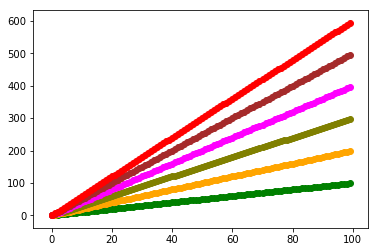

In [15]:
sourceColorsDict =  { 'good sources' : 'green',
                         'isolated parents':'orange',
                         'deblended children':'olive',
                         'blended object' :'magenta',
                         'negative fluxes': 'brown',
                         'flags: Edge or InterpolatedCenter': 'red'}

# Show what this selection looks like
N = 10
%matplotlib inline
#cmap = cm.get_cmap('jet',N)
x = np.arange(100)
colors = np.arange(N+1)/N
for  i,key in enumerate(sourceColorsDict.keys()):
    plt.scatter(x,x*(1+i),c=sourceColorsDict[key])
    

Plot a region 1000x1000 pixels for each CCD, iterating over the surface of each CCD until all is covered ... 

In [16]:
# Match clean DECAPS to clean LSST 
# once per visit 
cat12,title = cross_match_decaps_lsst(decaps_stack,lsst_stack,2)

# define an array of x,y to cover the entire CCD pretty much 
xs = [np.array([0,d]) + d*i for i in range(4)]
ys = [np.array([0,d]) + d*i for i in range(2)]

# for that visit,  plot various CCDs  
for i,ccdInt in enumerate(ccd_numbers[:1]) :
    image_data, px_scale = read_calexp_data(ccdInt, visit)
    for l, bounds in enumerate(product(xs,ys)):
        xbounds, ybounds = bounds
    #xbounds,ybounds = [3000, 3500], [1500, 2000]
        print(xbounds, ybounds)
        illustrate_ccd_region(image_data, cat12, lsst_stack, 
                      lsst_source_selection, px_scale,
                      ccdInt=ccdInt,
                      xbounds=xbounds, ybounds=ybounds, l = l,
                          decapsSnLimits=[50,200], decapsMags=[[18,19],[19,20]],
                          plot_raw_decaps = True , plot_raw_lsst = True,
                          savefig= True, useArcmin = False,
                          annotate = False, lowSNbyLine = False,
                          sourceTypePlot = ['good sources','S/N <5  sources',
                         'negative fluxes', 'flags: Edge or InterpolatedCenter'],
                          sourceColors = [ 'tab:orange', 'tab:green','tab:brown', 
                         'tab:red'],sourceColorD
                        )

SyntaxError: positional argument follows keyword argument (<ipython-input-16-05a293e0d200>, line 27)

In [35]:
ccdInt = 1
image_data, mask_data, px_scale = read_calexp_data(ccdInt, visit)

[0, 400] [1200, 1600]
Illustrating CCD  1
isolated parents
30
deblended children
99
Saving as  visit_527552_ccd_1.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


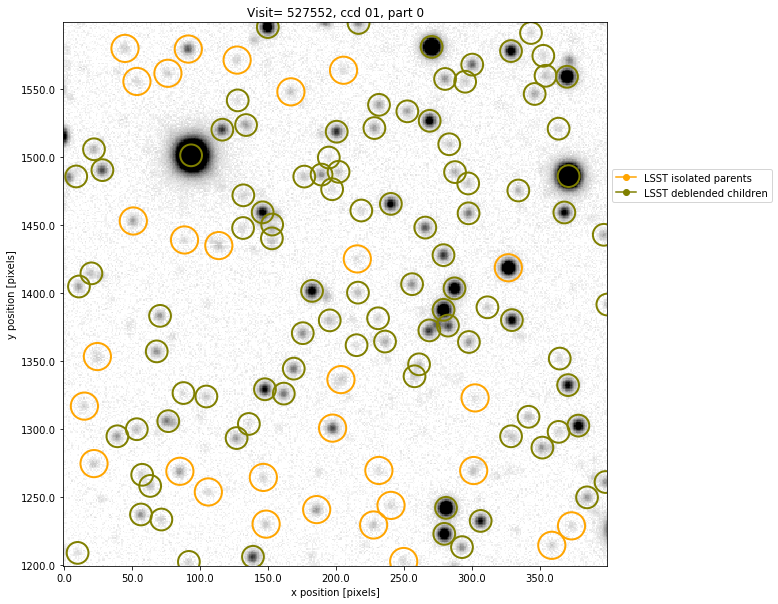

In [40]:
%matplotlib inline
# Show the position of blended source, and how we do not count one 

ccdInt = ccd_numbers[0]
image_data, mask_data, px_scale = read_calexp_data(ccdInt, visit)
#for l, bounds in enumerate(product(xs,ys)):
#xbounds, ybounds = bounds
l= 0
xbounds,ybounds = [0,400], [1200,1600]
print(xbounds, ybounds)
figname = 'visit_'+str(visit)+'_ccd_'+str(ccdInt)+'.png'
illustrate_ccd_region(image_data, cat12, lsst_stack, 
                  lsst_source_selection, px_scale,
                  ccdInt=ccdInt,
                  xbounds=xbounds, ybounds=ybounds, l = l,
                  decapsSnLimits=[50,200], decapsMags=[[18,19],[19,20]],
                  plot_raw_decaps = False , plot_raw_lsst = True,
                  savefig= True, useArcmin = False,fname=figname,
                  annotate = False, sourceTypePlot = [
                                    'isolated parents','deblended children',
                                     ],
                 plot_mask=False, 
                 mask_bits =   { 0:'MP_BAD',1:'MP_SAT',2:'MP_INTRP',3:'MP_CR',
                                4:'MP_EDGE', })
#  0:'MP_BAD',  1:'MP_SAT', 2:'MP_INTRP', 
#  3:'MP_CR', 4:'MP_EDGE',5:'MP_DETECTED',
#  6:'MP_DETECTED_NEGATIVE', 7:'MP_SUSPECT',8:'MP_NO_DATA'})

In [109]:
illustrate_ccd_region?

[0, 400] [1200, 1600]
Illustrating CCD  1
decaps missing lsst match  18 <m< 19 : 3
decaps missing lsst match  19 <m< 20 : 1
decaps with lsst match : 115
good sources
118
Saving as  visit_527552_ccd_1_lowSN.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


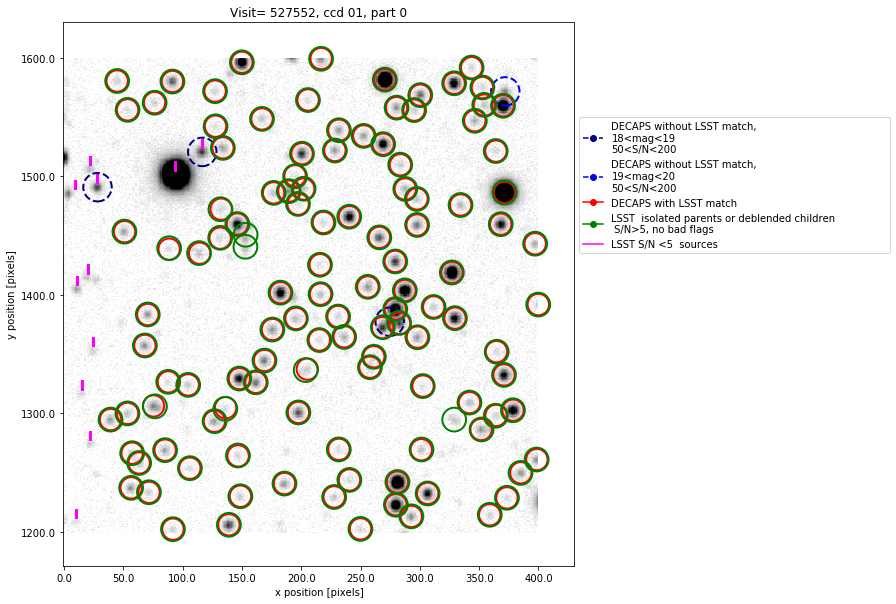

In [120]:
%matplotlib inline
# Show the position of blended source, and how we do not count one 

ccdInt = ccd_numbers[0]
image_data, mask_data, px_scale = read_calexp_data(ccdInt, visit)
#for l, bounds in enumerate(product(xs,ys)):
#xbounds, ybounds = bounds
l= 0
xbounds,ybounds = [0,400], [1200,1600]
print(xbounds, ybounds)
figname = 'visit_'+str(visit)+'_ccd_'+str(ccdInt)+'_lowSN.png'
illustrate_ccd_region(image_data, cat12, lsst_stack, 
                  lsst_source_selection, px_scale,
                  ccdInt=ccdInt,
                  xbounds=xbounds, ybounds=ybounds, l = l,
                  decapsSnLimits=[50,200], decapsMags=[[18,19],[19,20]],
                  plot_raw_decaps = True , plotDecapsMatches=True,
                      plot_raw_lsst = True,
                  savefig= True, useArcmin = False,fname=figname,
                  annotate = False, sourceTypePlot = ['good sources'],
                 plot_mask=False, lowSNbyLine=True,
                 mask_bits =   { 0:'MP_BAD',1:'MP_SAT',2:'MP_INTRP',3:'MP_CR',
                                4:'MP_EDGE', })
#  0:'MP_BAD',  1:'MP_SAT', 2:'MP_INTRP', 
#  3:'MP_CR', 4:'MP_EDGE',5:'MP_DETECTED',
#  6:'MP_DETECTED_NEGATIVE', 7:'MP_SUSPECT',8:'MP_NO_DATA'})

In [114]:
illustrate_ccd_region?

[0, 400] [1200, 1600]
Illustrating CCD  1
decaps missing lsst match  18 <m< 19 : 3
decaps missing lsst match  19 <m< 20 : 1
decaps with lsst match : 115
good sources
118
Saving as  visit_527552_ccd_1_all.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


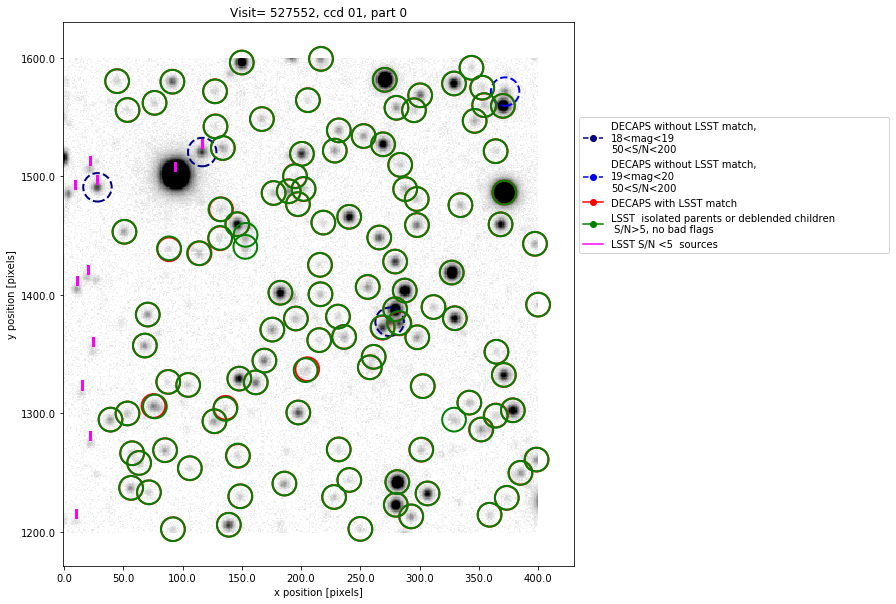

In [116]:
%matplotlib inline
# Show the position of blended source, and how we do not count one 

ccdInt = ccd_numbers[0]
image_data, mask_data, px_scale = read_calexp_data(ccdInt, visit)
#for l, bounds in enumerate(product(xs,ys)):
#xbounds, ybounds = bounds
l= 0
xbounds,ybounds = [0,400], [1200,1600]
print(xbounds, ybounds)
figname = 'visit_'+str(visit)+'_ccd_'+str(ccdInt)+'_all.png'
illustrate_ccd_region(image_data, cat12, lsst_stack, 
                  lsst_source_selection, px_scale,
                  ccdInt=ccdInt,
                  xbounds=xbounds, ybounds=ybounds, l = l,
                  decapsSnLimits=[50,200], decapsMags=[[18,19],[19,20]],
                  plot_raw_decaps = True , plotDecapsMatches=True,
                     plot_raw_lsst = True,
                  savefig= True, useArcmin = False,fname=figname,
                  annotate = False, sourceTypePlot = ['good sources'],
                 plot_mask=False, lowSNbyLine=True,
                 mask_bits =   { 0:'MP_BAD',1:'MP_SAT',2:'MP_INTRP',3:'MP_CR',
                                4:'MP_EDGE', })
#  0:'MP_BAD',  1:'MP_SAT', 2:'MP_INTRP', 
#  3:'MP_CR', 4:'MP_EDGE',5:'MP_DETECTED',
#  6:'MP_DETECTED_NEGATIVE', 7:'MP_SUSPECT',8:'MP_NO_DATA'})

In [ ]:
Plot S/N as a function of magnitude in LSST catalog ... 


In [ ]:
lsst_stack

[0, 200] [1400, 1600]
Illustrating CCD  1
decaps missing lsst match  18 <m< 19 : 2
decaps missing lsst match  19 <m< 20 : 0
isolated parents
9
deblended children
20
negative fluxes
0
flags: Edge or InterpolatedCenter
0
Saving as  visit_527552_ccd_01-0_detections.png


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


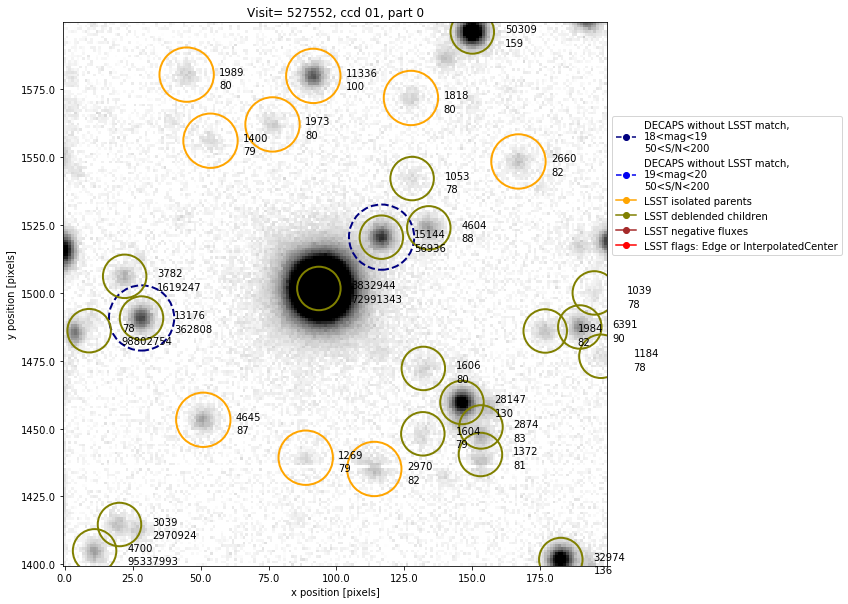

In [122]:
# Check out sources that are bright on the image , yet 
# the LSST 
#detection is very faint  - why ?  

# for that visit,  plot various CCDs  
for i,ccdInt in enumerate(ccd_numbers[:1]) :
    image_data, mask_data, px_scale = read_calexp_data(ccdInt, visit)
    #for l, bounds in enumerate(product(xs,ys)):
    #xbounds, ybounds = bounds
    xbounds,ybounds = [0,200], [1400,1600]
    print(xbounds, ybounds)
    illustrate_ccd_region(image_data, cat12, lsst_stack, 
                      lsst_source_selection, px_scale,
                      ccdInt=ccdInt,
                      xbounds=xbounds, ybounds=ybounds, l = l,
                      decapsSnLimits=[50,200], decapsMags=[[18,19],[19,20]],
                      plot_raw_decaps = True , plot_raw_lsst = True,
                      savefig= True, useArcmin = False,
                      annotate = True, 
                      sourceTypePlot = ['isolated parents','deblended children',
                      'negative fluxes', 'flags: Edge or InterpolatedCenter'])

In [637]:
x = lsst_stack['base_SdssCentroid_y']
y = lsst_stack['base_SdssCentroid_x']
xmin,xmax = [75,120] 
ymin,ymax = [1470, 1525]
choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
choose_ccd = lsst_stack['ccdnum'] == 1

choose_lowSN = lsst_source_selection['S/N <5  sources']
choose_deblended = lsst_source_selection['deblended children']
mask =  choose_pos * choose_ccd *choose_lowSN#*choose_deblended
lsst_stack[mask]

<Table masked=True length=3>
   lsst_mag    lsst_magerr     lsst_ra    ... deblend_nChild         id        
   float64       float64       float64    ...     int32            int64       
------------- ------------- ------------- ... -------------- ------------------
12.6101418063 20.6757733737 3.29902258042 ...              9 226581862988906618
 12.610168766 20.6758408818 3.29902257917 ...              0 226581862988909782
18.6183950118 4.08197381269  3.2990779742 ...              0 226581862988909784

In [42]:
lsst_stack

NameError: name 'lsst_stack' is not defined

51
19


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


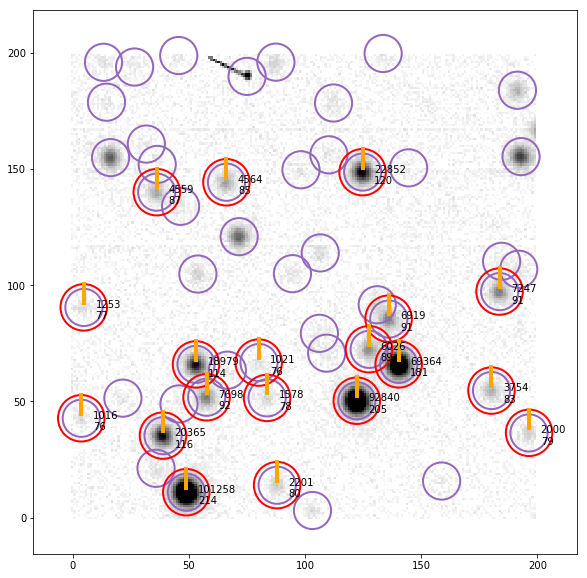

In [655]:
###
###  Testing how LSST  and DECAPS coordinate systems work ... 
###

xmin, xmax = 3800,4000
ymin, ymax = 1800,2000

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(image_data[xmin:xmax, ymin:ymax].T,
         cmap='Greys', origin='lower', norm=norm,
         vmax = 500, vmin = 2)

# decaps 
x = cat12['decaps_x']  # 0:4096
y = cat12['decaps_y']  # 0:2046 
choose_ccd = cat12['ccdnum'].data == ccdInt
choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
m = choose_ccd * choose_pos
print(np.sum(m))

xcords = x[m]
ycords = y[m]

for xx,yy in zip(xcords-xmin,ycords-ymin):
            circ = Circle((xx,yy), radius=8,alpha=1, lw=2,
                          fill=False, ec=color)
            ax.add_patch(circ)
# lsst 
y = lsst_stack['base_SdssCentroid_x']
x = lsst_stack['base_SdssCentroid_y']
choose_good = lsst_source_selection['good sources']
choose_pos = (xmin < x) * (x < xmax) * (ymin < y) * (y < ymax)
choose_ccd = lsst_stack['ccdnum'] == ccdInt
m =  choose_ccd * choose_pos*choose_good
print(np.sum(m))
xcords = x[m]
ycords = y[m]

annotate = True
f = lsst_stack['base_PsfFlux_flux'][m]
fErr = lsst_stack['base_PsfFlux_fluxSigma'][m]

color = colors[j]
for i, coords in enumerate(zip(xcords-xmin,ycords-ymin)):
    xx,yy = coords
    circ = Circle((xx,yy), radius=10,alpha=1, lw=2,
                  fill=False, ec='red')
    ax.add_patch(circ)
    
    if annotate : 
        ax.text(xx+5,yy,str(int(f[i])))
        ax.text(xx+5,yy-5,str(int(fErr[i])))
        
    ax.plot([xx,xx], [yy+2,yy+10],c='orange',lw=4)
    
# check positioning
circ = Circle((200,400), radius=25,alpha=1, lw=2,
                  fill=False, ec='orange')
ax.add_patch(circ)


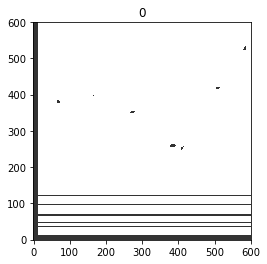

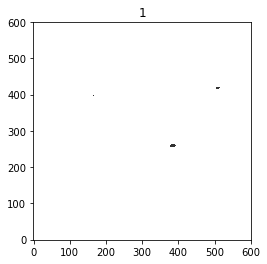

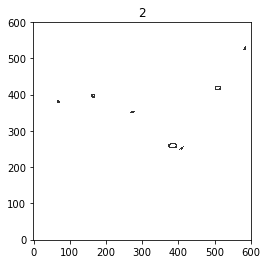

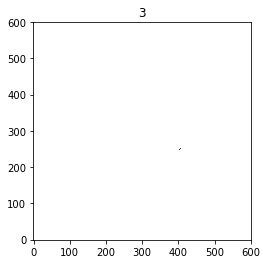

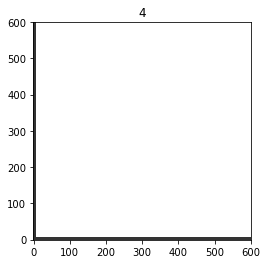

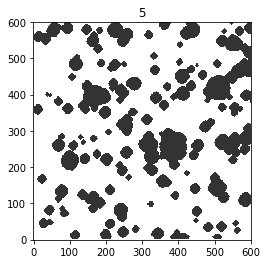

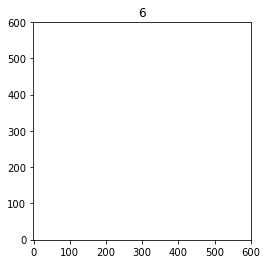

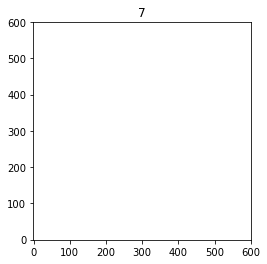

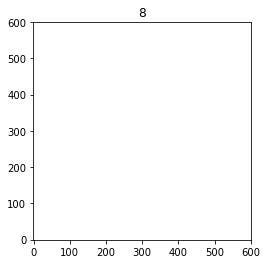

In [82]:
# Show what individual values of the mask look like ...
for i in range(9):
    mask_filter  = (2**i ) #+ 2**1 + 2**2 + 2**3 + 2**4 + 2**6 + 2**7 + 2**8)
    plt.title(i)
    plt.imshow(mask_data[xmin:xmax, ymin:ymax].astype(int).T & mask_filter, 
                cmap='Greys', origin='lower', norm=norm,
                 vmax = 1, vmin = 0, alpha=0.8)
    plt.show()


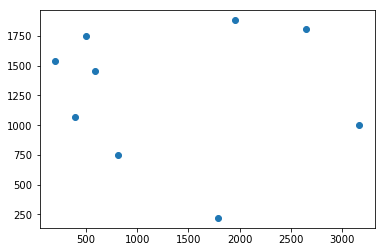

[Go to top](#toc)

### Illustrate different densities <a id='densities'></a>

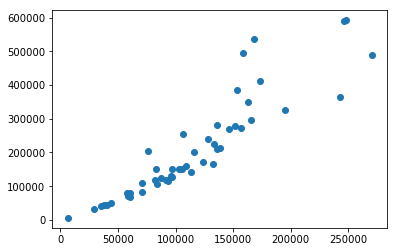

In [16]:
%matplotlib inline
# Illustrate different densities ....
visit_table = Table.read('decaps_lsst_visit_info.txt', format='ascii')
plt.scatter(visit_table['N_per_sq_deg_lsst'], visit_table['N_per_sq_deg_decaps'])

In [18]:
visit_table['N_per_sq_deg_decaps']  np.percentile(visit_table['N_per_sq_deg_decaps'], 95)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False], dtype=bool)

In [19]:
visit_table.sort('N_per_sq_deg_decaps')

In [22]:
visit_table[['visit', 'density_decaps','N_per_sq_deg_decaps' ]]

<Table length=50>
visit  density_decaps N_per_sq_deg_decaps
int64     float64            int64       
------ -------------- -------------------
568172           21.3                5989
527319           19.9               32071
530012           10.6               42145
525846           10.6               43746
525900           19.9               44876
529989           19.9               49296
527096           25.0               69162
525814           20.5               70268
644125           21.3               78380
529974           20.5               78958
   ...            ...                 ...
641500            7.7              324788
644082            3.0              350515
526028            7.7              364600
527064            4.2              385412
644011            6.7              412611
641548            6.7              490023
566793            1.7              493863
644144            1.7              535971
644074            5.1              589427
644070            5.1              591982

In [25]:
visit_table[50]

IndexError: index 50 out of range for table with length 50

In [27]:
visit_table[10]['N_per_sq_deg_decaps']

83518

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/astropy/visualization/stretch.py:115: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


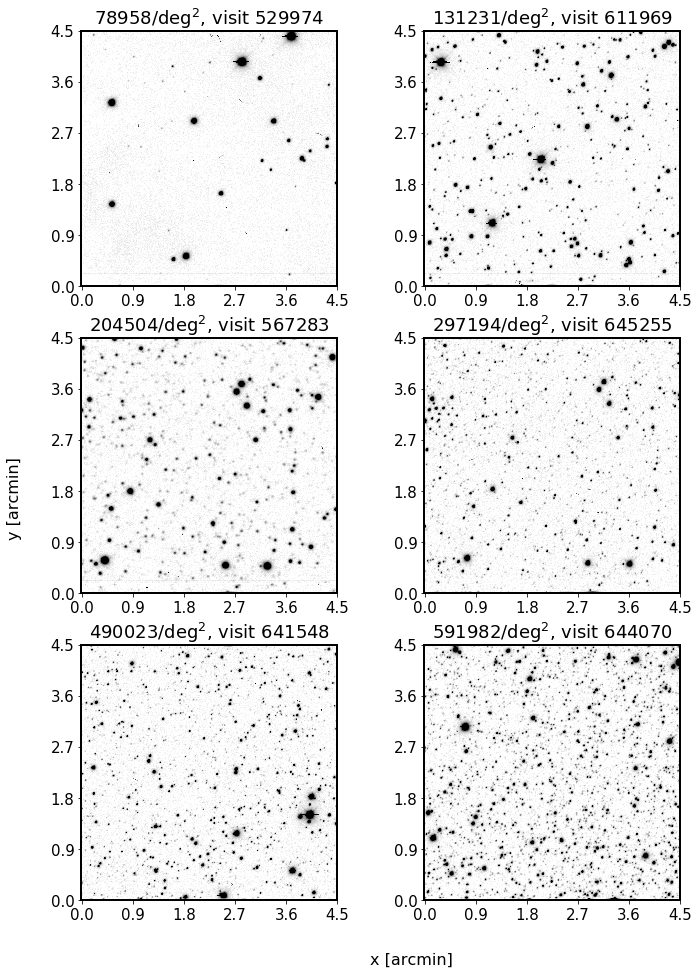

In [41]:

from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

positions  = [9,19,29,39,45,49]
fig,axs = plt.subplots(3,2, figsize=(12,16))
ax =  np.ravel(axs)
for j,position in enumerate(positions):
    visit = visit_table[position]['visit']
    density=  visit_table[position]['N_per_sq_deg_decaps']
    ccdnum = '01'
    outDir = '../data_products/LSST_Stack_processing/DECam/'+str(visit)+'/'
    calexp_file = 'calexp-0'+str(visit)+'_'+ccdnum+'.fits'
    calexp_hdu = fits.open(outDir +'calexp/'+ calexp_file)
    image_data = calexp_hdu[1].data
    xmin,xmax =0,1000
    ymin,ymax = 0,1000
    # show a small region of that CCD 
    norm = ImageNormalize(stretch=SqrtStretch())
    ax[j].imshow(image_data[xmin:xmax, ymin:ymax].T,
             cmap='Greys', origin='lower', norm=norm,
             vmax = 500, vmin = 2)

    x_px_scale = calexp_hdu[0].header['PIXSCAL1']
    y_px_scale = calexp_hdu[0].header['PIXSCAL2']

    # translate x ticks to arcsec
    new_labels = [str((item +xmin) * x_px_scale / 60) for item in ax[j].get_xticks()]
    ax[j].set_xticklabels(new_labels)

    # translate y ticks to arcsec
    new_labels = [str((item +ymin)* y_px_scale/60) for item in ax[j].get_yticks()]
    ax[j].set_yticklabels(new_labels)
    ax[j].set_title(str(density) +'/deg'+r'$^{2}$'+', '+\
                    'visit '+str(visit))
    
fig.text(0.5,0.07, 'x [arcmin]', fontsize=16)
fig.text(0.08, 0.5, 'y [arcmin]', rotation='vertical' ,fontsize=16)
fig.subplots_adjust(wspace=0.05)
plt.savefig('Illustrate_densities_DECAPS.png', bbox_inches='tight')
plt.show()

### Interpolation example... <a id='interpolation'></a>

[Jump to top](#toc)

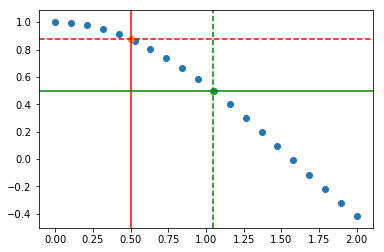

In [4]:
%matplotlib inline

# Example of using np.interp 
x = np.linspace(0,2,20)
y = np.cos(x)
plt.scatter(x,y)

# interpolating y at a given x,  
fp = np.interp(0.5, x,y)
plt.axvline(0.5, c='red')
plt.scatter(0.5,fp)
plt.axhline(fp, c='red', ls='--')

# interpolating x at a given y 
# note : whatever is given as x, has to be sorted !
s = np.argsort(y)   
xp = np.interp(0.5, y[s],x[s])
plt.axhline(0.5, c='green')
plt.scatter(xp,0.5)
plt.axvline(xp, c='green', ls='--')

# On the above plot, the  value of the axis at which we 
# need the value of the other axis is solid. So red shows
# that we are interpolating for y at x=0.5, and the green shows 
# that we are interpolating for x at y=0.5.  